<a href="https://colab.research.google.com/github/Kanisorn001/bsc_dpdm24/blob/main/Thal_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

#Import File

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/da/train_set.csv')
df.head(10)


,id number,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|,Thal_Group
0,67d169,25.0,11.1,34.0,78.0,3.2,0.0,55.9,4.358974,25.464706,32.647059,40.341026,18.141026,2.0,1.535294,3.070588,Abnormal_variants
1,67l168,32.0,13.9,42.0,86.0,3.7,0.3,54.8,5.197674,28.859060,33.557047,35.802326,5.802326,6.0,1.859060,11.154362,Abnormal_variants
2,67i267,43.0,10.1,31.0,78.0,2.6,0.3,56.2,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194,Abnormal_variants
3,67e248,33.0,12.9,38.0,76.0,3.0,0.2,61.2,5.000000,25.800000,33.947368,32.300000,6.500000,4.0,1.200000,4.800000,Abnormal_variants
4,67h277,23.0,12.9,40.0,78.0,3.1,0.0,55.6,5.128205,25.155000,32.250000,34.171795,8.371795,2.0,1.845000,3.690000,Abnormal_variants
5,67h283,57.0,9.8,32.0,76.0,3.7,0.0,64.4,4.210526,23.275000,30.625000,42.389474,22.789474,4.0,3.725000,14.900000,Abnormal_variants
6,67d341,74.0,10.1,31.0,78.0,2.3,0.0,76.2,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194,Abnormal_variants
7,67k76,39.0,10.1,31.0,78.0,3.7,0.0,52.3,3.974359,25.412903,32.580645,43.725641,23.525641,2.0,1.587097,3.174194,Abnormal_variants
8,66q131,78.0,8.9,27.0,84.0,3.9,0.0,54.5,3.214286,27.688889,32.962963,54.085714,36.285714,4.0,0.688889,2.755556,Abnormal_variants
9,66s257,NaN,11.6,31.7,82.0,3.7,0.0,52.2,3.865854,30.006309,36.231884,43.334146,20.134146,2.0,3.006309,6.012618,Abnormal_variants


#Data Preparation

##Handle null values

In [ ]:
# prompt: ดูค่า null

df.isnull().sum()


,0
id number,0
Xn,435
Hb(Gm%),7
Hct(%),7
MCV(fl),7
A2 (2-3%),133
HbF (2%),116
HbA (95-97%),116
RBC,7
MCH,7


In [ ]:
df.dropna(inplace=True)

df.isnull().sum()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3795 entries, 0 to 4321
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id number          3795 non-null   object 
 1   Xn                 3795 non-null   float64
 2   Hb(Gm%)            3795 non-null   float64
 3   Hct(%)             3795 non-null   float64
 4   MCV(fl)            3795 non-null   float64
 5   A2 (2-3%)          3795 non-null   float64
 6   HbF (2%)           3795 non-null   float64
 7   HbA (95-97%)       3795 non-null   float64
 8   RBC                3795 non-null   float64
 9   MCH                3795 non-null   float64
 10  MCHC               3795 non-null   float64
 11  MCV-RBC-3*HGB      3795 non-null   float64
 12  MCV-RBC-5*HGB      3795 non-null   float64
 13  |80-MCV|           3795 non-null   float64
 14  |27-MCH|           3795 non-null   float64
 15  |80-MCV|*|27-MCH|  3795 non-null   float64
 16  Thal_Group         3795 non-n

In [ ]:

df = df.drop('id number', axis=1)


##Correlation Matrix of Features

In [ ]:
# แปลงตัวแปรเป้าหมายเป็นตัวเลขสำหรับคำนวณความสัมพันธ์
df_encoded = df.copy()
df_encoded["Thal_Group"] = df_encoded["Thal_Group"].astype("category").cat.codes

# คำนวณความสัมพันธ์ของตัวแปรเชิงตัวเลขกับ Thal_Group
correlation_matrix = df_encoded.corr()["Thal_Group"].abs().sort_values(ascending=False)
correlation_matrix

,Thal_Group
Thal_Group,1.000000
MCH,0.544606
MCV(fl),0.541468
|27-MCH|,0.535454
|80-MCV|,0.518120
MCV-RBC-3*HGB,0.447132
|80-MCV|*|27-MCH|,0.415369
MCV-RBC-5*HGB,0.307296
MCHC,0.302672
RBC,0.298016


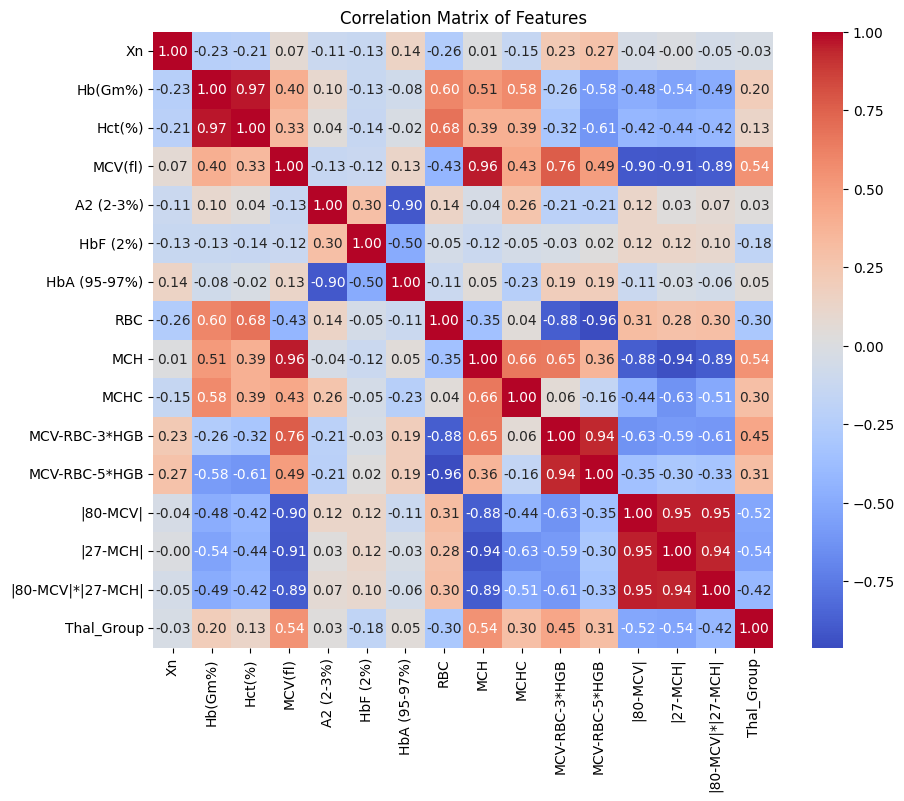

In [ ]:
# prompt: plot correlation_matrix

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


#Modeling

##Define feature

In [ ]:
selected_features = ["MCH", "MCV(fl)", "|27-MCH|", "|80-MCV|", "MCV-RBC-3*HGB","|80-MCV|*|27-MCH|","MCV-RBC-5*HGB", "RBC", "MCHC", "Hb(Gm%)","HbF (2%)","Hct(%)"]
X = df[selected_features]
y = df["Thal_Group"].astype("category").cat.codes  # แปลงเป็นตัวเลข

##Split Data

In [ ]:
# 5. แบ่ง Train-Test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##Model Selection

In [ ]:
# 6. สร้างโมเดล
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

# 7. ใช้ Stratified K-Fold Cross Validation (5 Folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 8. Train และวัดผลลัพธ์
results = {}

for model_name, model in models.items():
    y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    accuracy = accuracy_score(y_train, y_pred_cv)
    recall = recall_score(y_train, y_pred_cv, average="weighted")
    precision = precision_score(y_train, y_pred_cv, average="weighted")
    f1 = f1_score(y_train, y_pred_cv, average="weighted")

    results[model_name] = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1
    }

# 9. แสดงผลลัพธ์
results_df = pd.DataFrame(results).T
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populate

               Accuracy    Recall  Precision  F1-Score
Decision Tree  0.735178  0.735178   0.737094  0.736027
Naive Bayes    0.340250  0.340250   0.503725  0.380913
Random Forest  0.772069  0.772069   0.773349  0.770866
XGBoost        0.781621  0.781621   0.780670  0.780175


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Train model

###Grid Search

In [ ]:
best_model_name = max(results, key=lambda k: results[k]["F1-Score"])
best_model = models[best_model_name]

# กำหนดค่าพารามิเตอร์สำหรับ Grid Search ตามโมเดลที่เลือก
param_grid = {}
if best_model_name == "XGBoost":
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.01, 0.1, 0.3],
        "subsample": [0.7, 1.0]
    }

# ทำ Grid Search เพื่อหา parameter ที่ดีที่สุด
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring="f1_weighted", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train โมเดลด้วยพารามิเตอร์ที่ดีที่สุด
best_model_tuned = grid_search.best_estimator_
best_model_tuned.fit(X_train, y_train)

best_model_name, grid_search.best_params_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


('XGBoost',
 {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0})

##Test Data

In [ ]:
# ทดสอบโมเดลกับ X_test
y_pred_test = best_model_tuned.predict(X_test)

# คำนวณผลลัพธ์บน Test Set
test_results = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Recall": recall_score(y_test, y_pred_test, average="weighted"),
    "Precision": precision_score(y_test, y_pred_test, average="weighted"),
    "F1-Score": f1_score(y_test, y_pred_test, average="weighted")
}

# แสดงผลลัพธ์
test_results

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.8115942028985508,
 'Recall': 0.8115942028985508,
 'Precision': 0.8108725464056684,
 'F1-Score': 0.8099537834094657}


#Predict x_test

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/da/X_test.csv')
df_test.head(10)

,id number,Xn,Hb(Gm%),Hct(%),MCV(fl),A2 (2-3%),HbF (2%),HbA (95-97%),RBC,MCH,MCHC,MCV-RBC-3*HGB,MCV-RBC-5*HGB,|80-MCV|,|27-MCH|,|80-MCV|*|27-MCH|
0,66z133,38.0,12.4,37.0,78.0,2.7,1.3,75.4,4.743590,26.140541,33.513514,36.056410,11.256410,2.0,0.859459,1.718919
1,66z297,28.0,12.8,39.4,82.0,2.7,0.0,97.3,4.804878,26.639594,32.487310,38.795122,13.195122,2.0,0.360406,0.720812
2,66u491,78.0,10.9,33.9,79.0,3.1,0.0,96.9,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820
3,66x072,65.0,10.9,33.9,79.0,3.0,0.2,87.9,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820
4,67m031,17.0,11.5,36.0,78.0,2.8,0.8,79.6,4.615385,24.916667,31.944444,38.884615,15.884615,2.0,2.083333,4.166667
5,67f446,36.0,10.9,33.9,79.0,2.8,0.0,97.2,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820
6,66s429,40.0,13.7,37.5,80.0,3.0,0.2,86.0,4.687500,29.226667,34.821429,34.212500,6.812500,0.0,2.226667,0.000000
7,66a151,44.0,7.1,25.0,63.0,2.1,0.2,87.6,3.968254,17.892000,28.400000,37.731746,23.531746,17.0,9.108000,154.836000
8,66a391,71.0,10.9,33.9,79.0,2.5,0.0,97.5,4.291139,25.401180,32.153392,42.008861,20.208861,1.0,1.598820,1.598820
9,67d241,25.0,4.4,15.1,63.0,2.9,0.5,87.2,2.396825,18.357616,29.139073,47.403175,38.603175,17.0,8.642384,146.920530


In [ ]:
# prompt: Drop null df_test

df_test.dropna(inplace=True)


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1759 entries, 0 to 1996
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id number          1759 non-null   object 
 1   Xn                 1759 non-null   float64
 2   Hb(Gm%)            1759 non-null   float64
 3   Hct(%)             1759 non-null   float64
 4   MCV(fl)            1759 non-null   float64
 5   A2 (2-3%)          1759 non-null   float64
 6   HbF (2%)           1759 non-null   float64
 7   HbA (95-97%)       1759 non-null   float64
 8   RBC                1759 non-null   float64
 9   MCH                1759 non-null   float64
 10  MCHC               1759 non-null   float64
 11  MCV-RBC-3*HGB      1759 non-null   float64
 12  MCV-RBC-5*HGB      1759 non-null   float64
 13  |80-MCV|           1759 non-null   float64
 14  |27-MCH|           1759 non-null   float64
 15  |80-MCV|*|27-MCH|  1759 non-null   float64
dtypes: float64(15), object(1)
mem

In [ ]:

# ทำนายผลลัพธ์จาก df_test
y_pred_df_test = best_model_tuned.predict(df_test[selected_features])

# สร้าง DataFrame เพื่อเก็บผลลัพธ์
result_df = pd.DataFrame({'Predicted_Thal_Group': y_pred_df_test})

# แปลงค่าตัวเลขกลับเป็นชื่อกลุ่มเดิม
thal_group_mapping = dict(enumerate(df["Thal_Group"].astype("category").cat.categories))
result_df['Predicted_Thal_Group'] = result_df['Predicted_Thal_Group'].map(thal_group_mapping)

# แสดงผลลัพธ์
print(result_df.head())


  Predicted_Thal_Group
0               Normal
1               Normal
2               Normal
3               Normal
4          HbE_related


In [ ]:

# Save the results to a CSV file in Google Drive
result_df.to_csv('/content/drive/My Drive/y_pred.csv', index=False)
